In [1]:
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')

In [2]:
import sys
sys.path.append('../')
import dataset_wrapper as util

In [4]:
import ee
ee.Authenticate() 
ee.Initialize()

In [6]:
import geopandas as gpd
dataframe = gpd.read_file('/data2/hkaman/Data/CDL/California_Counties.geojson')
dataframe = dataframe.to_crs(epsg=4326)
dataframe

,OBJECTID,NAME,STATE_NAME,STATE_FIPS,CNTY_FIPS,FIPS,Shape__Area,Shape__Length,geometry
0,1,Alameda County,California,06,001,06001,3.084661e+09,4.484258e+05,"MULTIPOLYGON (((-122.19112 37.69298, -122.1910..."
1,2,Alpine County,California,06,003,06003,3.156006e+09,2.755651e+05,"POLYGON ((-119.90061 38.93077, -119.88726 38.9..."
2,3,Amador County,California,06,005,06005,2.562531e+09,3.595932e+05,"POLYGON ((-120.07765 38.70889, -120.07771 38.7..."
3,4,Butte County,California,06,007,06007,7.340033e+09,5.259746e+05,"POLYGON ((-121.40463 40.14665, -121.40489 40.1..."
4,5,Calaveras County,California,06,009,06009,4.356209e+09,3.670057e+05,"POLYGON ((-120.07247 38.50916, -120.07254 38.4..."
5,6,Colusa County,California,06,011,06011,4.990775e+09,3.860411e+05,"POLYGON ((-122.10655 39.41443, -122.10278 39.4..."
6,7,Contra Costa County,California,06,013,06013,3.075717e+09,4.515488e+05,"MULTIPOLYGON (((-122.37203 37.90142, -122.3717..."
7,8,Del Norte County,California,06,015,06015,4.715185e+09,4.214900e+05,"MULTIPOLYGON (((-124.11103 41.59347, -124.1112..."
8,9,El Dorado County,California,06,017,06017,7.624185e+09,4.677944e+05,"POLYGON ((-119.90433 38.93333, -119.90442 38.9..."
9,10,Fresno County,California,06,019,06019,2.430318e+10,1.104287e+06,"POLYGON ((-119.00148 37.57090, -119.00097 37.5..."


### Climate data

In [5]:
for year in range(2008, 2009):
    dataset = util.DownloadClimateEE(year = year, county_name= 'Alameda')()

NetCDF file saved to /data2/hkaman/Data/FoundationModel/Alameda/Climate/2008/DayMet_Alameda_2008.nc


In [57]:
import rioxarray
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from shapely.geometry import box
import geopandas as gpd




# Input files
climate_data_dir = '/data2/hkaman/Data/FoundationModel/Alameda/Climate/2008/DayMet_Alameda_2008.nc'
landsat_reference = '/data2/hkaman/Data/FoundationModel/Monterey/Landsat/2008/Monterey_LT_20080207.tif'

# Open Landsat reference for CRS and transform
with rasterio.open(landsat_reference) as landsat_src:
    reference_crs = landsat_src.crs
    reference_transform = landsat_src.transform
    reference_resolution = landsat_src.res  # (x_resolution, y_resolution)
    reference_bounds = landsat_src.bounds
    reference_width = landsat_src.width
    reference_height = landsat_src.height

# Open climate data
ds = xr.open_dataset(climate_data_dir)

# Manually define the transform using Landsat bounds and resolution
# from rasterio.transform import from_bounds
# corrected_transform = from_bounds(
#     reference_bounds.left,
#     reference_bounds.bottom,
#     reference_bounds.right,
#     reference_bounds.top,
#     ds.to_array().shape[2],
#     ds.to_array().shape[3]
# )


# print(reference_bounds.left, reference_bounds.bottom,reference_bounds.right,reference_bounds.top,)
# Assign the corrected transform to the dataset
# ds = ds.rio.write_transform(corrected_transform)
ds = ds.rio.write_crs("EPSG:4269")
# ds_reprojected = ds.rio.reproject(
#     reference_crs,
#     resampling=Resampling.bilinear
# )
# ds_reprojected


In [65]:
landsat_src.transform

Affine(30.0, 0.0, 591345.0,
       0.0, -30.0, 4086765.0)

In [60]:
ds.rio.transform()

Affine(1000.0, 0.0, -1867750.0,
       0.0, -1000.0, -352500.0)

In [73]:
from pyproj import Transformer
from shapely.geometry import box

# Check original CRS and bounds
print("Original Climate CRS:", ds.rio.crs)
print("Original Climate Bounds:", ds.rio.bounds())

# Assign correct CRS if necessary
if ds.rio.crs is None or str(ds.rio.crs) != "EPSG:4269":
    print("Assigning CRS...")
    ds = ds.rio.write_crs("EPSG:4269")  # Replace with actual CRS if incorrect

# Recheck bounds
source_bounds = ds.rio.bounds()
print("Rechecked Source Bounds:", source_bounds)

# Initialize transformer
try:
    transformer = Transformer.from_crs("EPSG:4269", reference_crs, always_xy=True)

    # Transform bounds
    transformed_bounds = transformer.transform_bounds(*source_bounds)
    print("Transformed Source Bounds (to match Destination CRS):", transformed_bounds)
except Exception as e:
    print("Error during transformation:", str(e))

# Check overlap
source_box = box(*source_bounds)
destination_box = box(reference_bounds.left, reference_bounds.bottom,
                      reference_bounds.right, reference_bounds.top)

if not source_box.intersects(destination_box):
    print("No overlap between source and destination bounds.")
else:
    print("Source and destination bounds overlap.")

Original Climate CRS: EPSG:4269
Original Climate Bounds: (-1867750.0, -500500.0, -1739750.0, -352500.0)
Rechecked Source Bounds: (-1867750.0, -500500.0, -1739750.0, -352500.0)
Transformed Source Bounds (to match Destination CRS): (inf, inf, inf, inf)
No overlap between source and destination bounds.


In [74]:
reference_crs

CRS.from_epsg(32610)

In [ ]:
import numpy as np
import xarray as xr
from rasterio.warp import reproject, Resampling
from rasterio.transform import from_bounds
from shapely.geometry import box
from pyproj import Transformer

# Input climate and Landsat data
climate_data_dir = '/data2/hkaman/Data/FoundationModel/Monterey/Climate/2008/DayMet_Monterey_2008.nc'
landsat_reference = '/data2/hkaman/Data/FoundationModel/Monterey/Landsat/2008/Monterey_LT_20080207.tif'

# Open climate dataset
ds = xr.open_dataset(climate_data_dir)

# Rename spatial dimensions if needed
if "lon" in ds.dims and "lat" in ds.dims:
    ds = ds.rename({"lon": "x", "lat": "y"})

# Set spatial dimensions for rioxarray
ds = ds.rio.set_spatial_dims(x_dim="x", y_dim="y")

# Assign correct CRS to the climate dataset (e.g., North America Lambert Conformal Conic)
climate_crs = "EPSG:4269"  # Adjust based on your dataset's actual CRS
ds = ds.rio.write_crs(climate_crs)

# Open Landsat dataset for reference CRS and bounds
with rasterio.open(landsat_reference) as landsat_src:
    reference_crs = landsat_src.crs
    reference_bounds = landsat_src.bounds
    reference_transform = landsat_src.transform
    reference_width = landsat_src.width
    reference_height = landsat_src.height

# Transformer for CRS conversion
transformer = Transformer.from_crs(climate_crs, reference_crs, always_xy=True)

# Transform source bounds to destination CRS
source_bounds = ds.rio.bounds()
transformed_bounds = transformer.transform_bounds(*source_bounds)

print("Source Bounds (Original CRS):", source_bounds)
print("Transformed Source Bounds (to match Destination CRS):", transformed_bounds)
print("Destination Bounds (Landsat):", reference_bounds)

# Variables to reproject
variable_names = ['tmin', 'tmax', 'prcp', 'dayl', 'srad', 'snow', 'vp', 'pet']

# Generate destination transform based on Landsat bounds and climate resolution
dst_transform = from_bounds(
    reference_bounds.left,
    reference_bounds.bottom,
    reference_bounds.right,
    reference_bounds.top,
    ds.sizes['x'],  # Number of columns in climate data
    ds.sizes['y']   # Number of rows in climate data
)

# Dictionary to store reprojected variables
reprojected_vars = {}

# Reproject each variable
for var_name in variable_names:
    print(f"Reprojecting variable: {var_name}")
    var_data = ds[var_name]
    data_dtype = var_data.dtype

    # Create empty array for the reprojected data
    reprojected_data = np.zeros((ds.sizes['time'], ds.sizes['y'], ds.sizes['x']), dtype=data_dtype)

    # Verify bounds overlap
    source_box = box(*transformed_bounds)
    destination_box = box(reference_bounds.left, reference_bounds.bottom,
                          reference_bounds.right, reference_bounds.top)

    # if not source_box.intersects(destination_box):
    #     print(f"No overlap between transformed source and destination bounds for {var_name}. Skipping.")
    #     continue

    # Loop through each time slice for reprojection
    for i, time_slice in enumerate(ds["time"]):
        # print(f"Reprojecting time slice {i}...")
        
        # Verify source data
        source = var_data.isel(time=i).values
        if not np.any(source):
            print(f"Time slice {i} contains only zero data. Skipping.")
            continue

        # Reproject
        reproject(
            source=source,  # Source data
            destination=reprojected_data[i],  # Destination array
            src_transform=ds.rio.transform(),  # Original climate transform
            src_crs=ds.rio.crs,  # Original climate CRS
            dst_transform=dst_transform,  # Adjusted destination transform
            dst_crs=reference_crs,  # Destination CRS (Landsat)
            resampling=Resampling.bilinear  # Resampling method
        )

    # Generate new x and y coordinates
    x_coords = np.linspace(reference_bounds.left, reference_bounds.right, ds.sizes['x'])
    y_coords = np.linspace(reference_bounds.top, reference_bounds.bottom, ds.sizes['y'])

    # Assign coordinates and dimensions
    coords = {
        "time": ds["time"],
        "x": x_coords,
        "y": y_coords,
    }
    dims = ("time", "y", "x")

    # Store the reprojected data
    reprojected_vars[var_name] = xr.DataArray(reprojected_data, coords=coords, dims=dims)

# Combine all reprojected variables into a new dataset
reprojected_ds = xr.Dataset(reprojected_vars)

# Assign the CRS to the reprojected dataset
reprojected_ds = reprojected_ds.rio.write_crs(reference_crs)

# Validate the output
print("Reprojected Dataset CRS:", reprojected_ds.rio.crs)
print("Reprojected Dataset Bounds:", reprojected_ds.rio.bounds())

# Plot for visualization
import matplotlib.pyplot as plt
for var_name in variable_names:
    print(f"Visualizing {var_name}...")
    reprojected_ds[var_name].isel(time=0).plot(cmap='viridis')
    plt.title(f"Reprojected Climate Data ({var_name})")
    plt.show()

In [63]:
print("Reprojected Climate Bounds:", reprojected_ds.rio.bounds())
print("Reference Bounds:", reference_bounds)

Reprojected Climate Bounds: (590713.2283464567, 3962052.2448979593, 752446.7716535433, 4087187.7551020407)
Reference Bounds: BoundingBox(left=591345.0, bottom=3962475.0, right=751815.0, top=4086765.0)


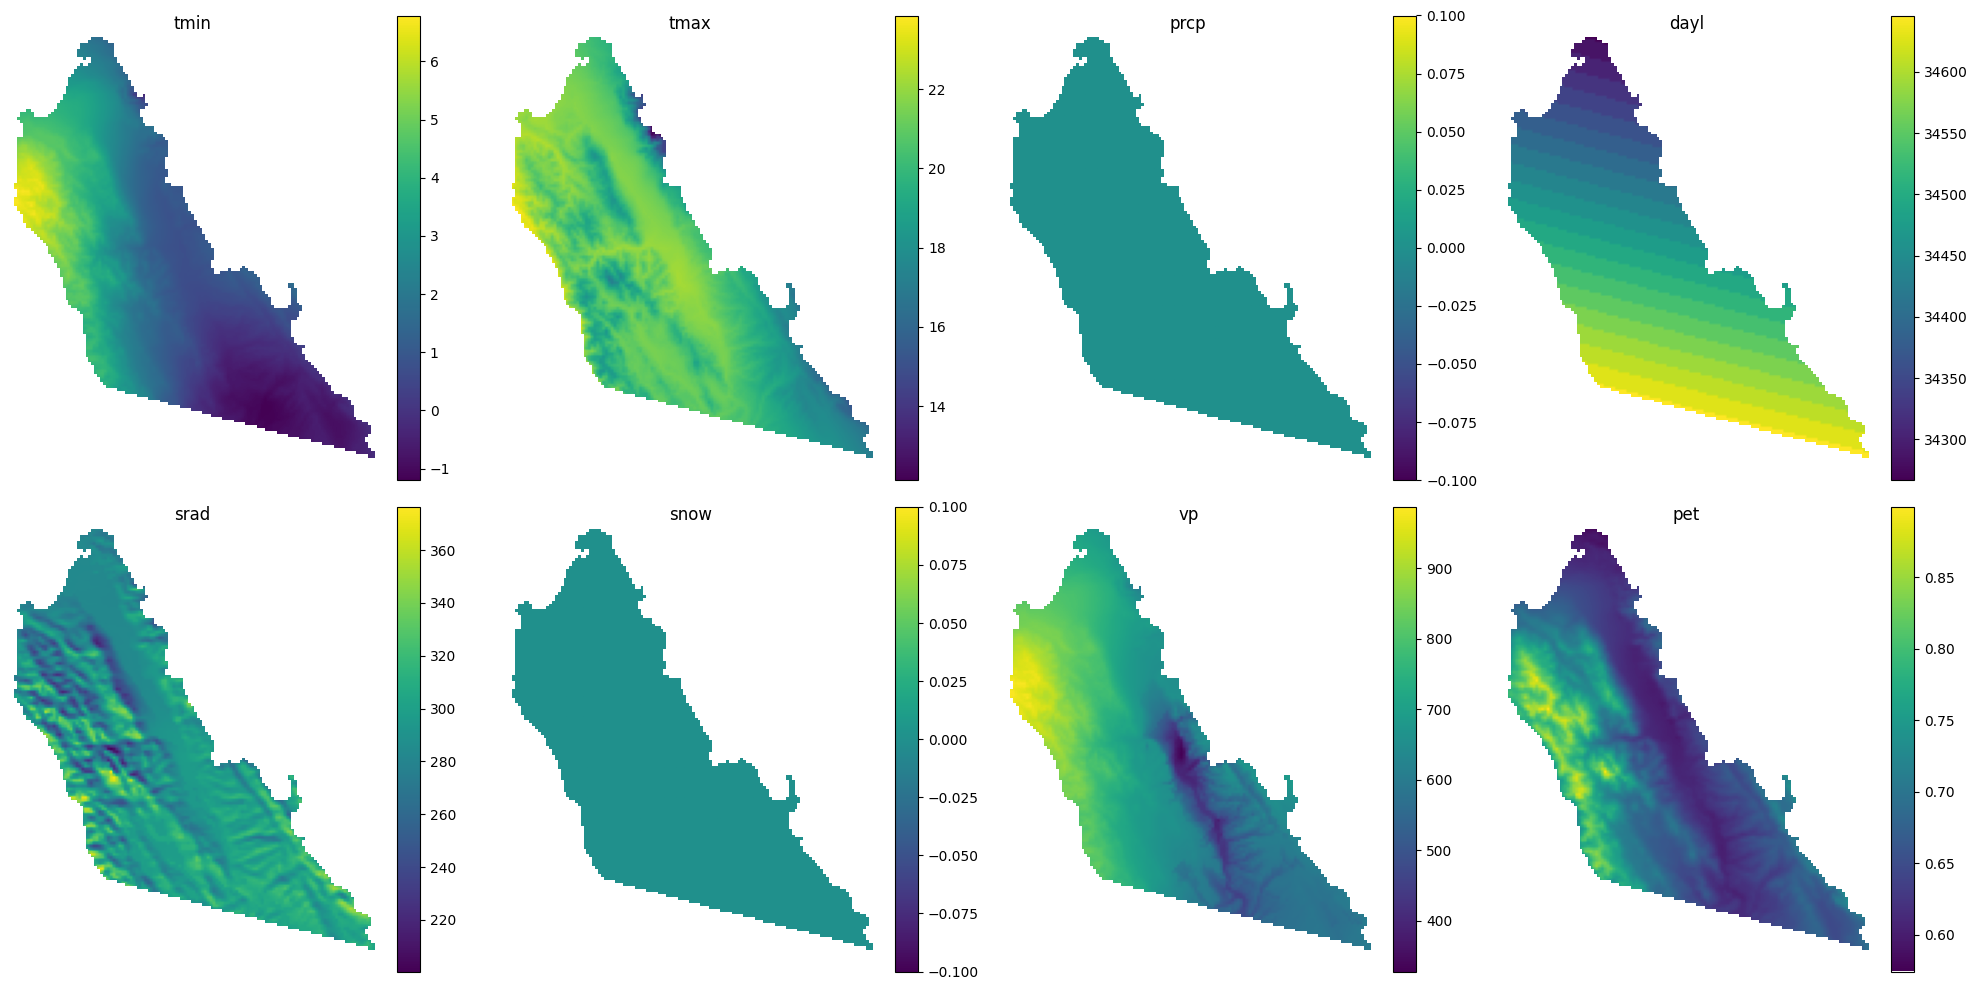

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns
variables_to_plot = [0, 1, 2, 3]  # Indices of the variables to plot
variable_names = ['tmin', 'tmax', 'prcp', 'dayl', 'srad', 'snow', 'vp', 'pet']  # Corresponding variable names

# Create a 2x4 grid for plotting
fig, axs = plt.subplots(2, 4, figsize=(20, 10))
# Plot each variable
for i, var_name in enumerate(variable_names):
    row, col = divmod(i, 4)  # Compute row and column index for axs
    ax = axs[row, col]  # Access the subplot in the 2x4 grid

    # Ensure the variable exists in the dataset
    if var_name in reprojected_ds:
        data = reprojected_ds[var_name].isel(time=0).to_numpy()  # Extract time=0 data as NumPy array
        im = ax.imshow(data, cmap='viridis')  # Plot the data
        ax.set_title(var_name)  # Set the subplot title
        ax.axis('off')  # Turn off axes for cleaner visualization
        fig.colorbar(im, ax=ax, orientation='vertical')  # Add a colorbar for each plot
    else:
        ax.set_title(f"{var_name} not found")  # Handle missing variables
        ax.axis('off')  # Leave the subplot blank

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


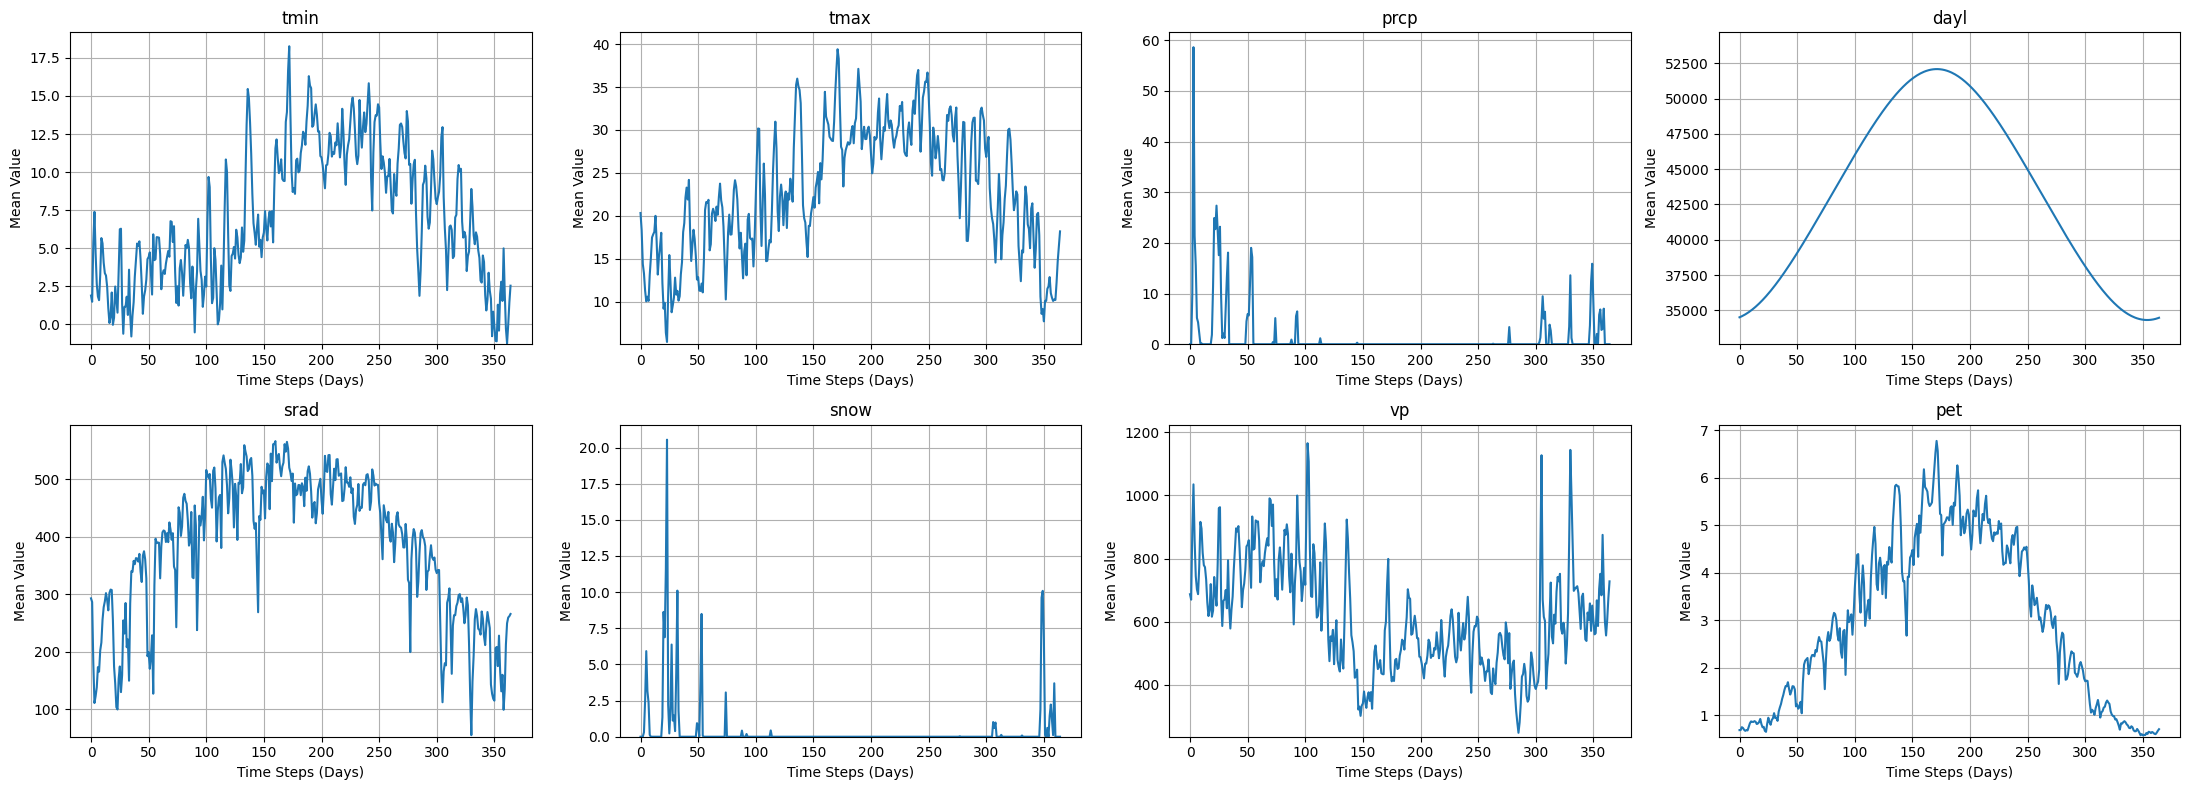

In [55]:
import numpy as np
time_steps = 365
spatial_dims = (128, 148)
variable_names = ['tmin', 'tmax', 'prcp', 'dayl', 'srad', 'snow', 'vp', 'pet']
fig, axs = plt.subplots(2, 4, figsize=(22, 8))

# Plot each variable's mean time series
for i, var_name in enumerate(variable_names):
    row, col = divmod(i, 4)  # Compute row and column index for axs
    ax = axs[row, col]  # Access the subplot in the 2x4 grid

    # Compute the mean over spatial dimensions (latitude and longitude)
    mean_time_series = ds[var_name].mean(axis=(1, 2))  # Mean over spatial dimensions

    # Plot the mean time series
    ax.plot(mean_time_series, label=var_name)
    ax.set_title(var_name)  # Set the title for each subplot
    ax.set_xlabel("Time Steps (Days)")
    ax.set_ylabel("Mean Value")

    # Set individual y-axis range based on data
    ax.set_ylim(mean_time_series.min() - 0.05 * abs(mean_time_series.min()), 
                mean_time_series.max() + 0.05 * abs(mean_time_series.max()))

    ax.grid(True)

# Adjust layout for better spacing
plt.tight_layout()
plt.show()